# Comparsion Network Implementation

We would like to research how these different network architectures can accelerate queries and if it demonstrates a potential for speeding up computer graphic queries like bounding, ray intersection tests.

1. one MLP for one image
2. two MLP for one image, split is fixed
3. two MLP for one image, best split is randomly found out of n random tries
4. two MLP for one image, best split is result of clasifcying space using a network (~MoE) - soft gated MoE
5. two MLP for one image, best split is result of clasifcying space using a network (~MoE) - sparse MoE

Load dependencies

In [225]:
import jax
import jax.numpy as jnp
import optax
import IPython as ip
import matplotlib as mp
import matplotlib.pyplot as plt
import time
import numpy as np
import json
from jax import random, grad, jit
from flax import struct

### Load image
and define image sampling functions for training.

Image intensity range: 0.0 to 1.0
Example sampling (Coordinates, Intensities): (Array([[0.37528604, 0.16666667],
       [0.08466819, 0.37356323],
       [0.19450802, 0.5373563 ]], dtype=float32), Array([[0.05490196, 0.34901962, 0.5764706 ],
       [0.01960784, 0.3647059 , 0.60784316],
       [0.24705882, 0.73333335, 0.91764706]], dtype=float32))


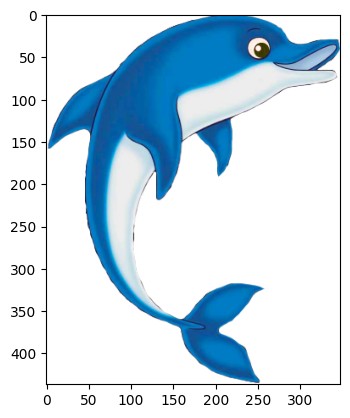

In [257]:
# Initialize random key
key = random.PRNGKey(28)

# Load and preview image normalized
# Separate color and alpha channel
img_rgba = jnp.array(plt.imread("dolphin_color.png"))
colors, mask = img_rgba[...,0:3], img_rgba[...,3].astype(bool)

# Define function to sample non transparent region of image
# when learning image
def sample_img(colors, mask, n_samples, key):
    
    # Extract n non-masked pixel coordinates (x) and colors (y)
    p_x, p_y = jnp.meshgrid(jnp.arange(img_rgba.shape[0]),jnp.arange(img_rgba.shape[1]), indexing='ij')
    p_x = jnp.stack((p_x, p_y),axis=-1)[mask]
    x = p_x[random.choice(random.split(key)[1], p_x.shape[0], (n_samples,))]
    y = colors[x[...,0], x[...,1]]
    x = x.at[...,0].divide(img_rgba.shape[0])
    x = x.at[...,1].divide(img_rgba.shape[1])

    return x, y

# Define function to sample non transparent region of image
# and subgroup based on image split mask for task 2 and 3
def sample_img_regions(colors, mask, n_samples, key, region_mask):
    
    # Extract n non-masked pixel coordinates (x) and colors (y)
    p_x, p_y = jnp.meshgrid(jnp.arange(img_rgba.shape[0]),jnp.arange(img_rgba.shape[1]), indexing='ij')

    # Pick random samples in both regions equally
    # We use the alpha mask from the image combined with the region mask 
    # to sample the assigned region of the dolphin for each of the both models
    n_samples = int(n_samples / 2)
    p1_coords = jnp.stack((p_x, p_y),axis=-1)[mask * region_mask]
    x1 = p1_coords[random.choice(random.split(key)[1], p1_coords.shape[0], (n_samples,))]
    p2_coords = jnp.stack((p_x, p_y),axis=-1)[mask * ~region_mask]
    x2 = p2_coords[random.choice(random.split(key)[1], p2_coords.shape[0], (n_samples,))]
    x = jnp.stack((x1, x2), axis=0)
    
    # Normalize coordinates and extract color labels
    y = colors[x[...,0], x[...,1]]
    x = x.at[...,0].divide(img_rgba.shape[0])
    x = x.at[...,1].divide(img_rgba.shape[1])

    return x, y

# Validate and display
print(f"Image intensity range: {jnp.min(img_rgba)} to {jnp.max(img_rgba)}")
plt.imshow(img_rgba)
print(f"Example sampling (Coordinates, Intensities): {sample_img(colors,mask, 3, key)}")

### Shared Helper Functions

In [101]:
# Initalize parameters of network (weights and biases)
def init_mlp(layer_dims, key):
    p = []
    keys = random.split(key, len(layer_dims))
    for k, (n_in, n_out) in zip(keys, zip(layer_dims[:-1], layer_dims[1:])):
        W = random.normal(k, (n_in, n_out)) * 0.1
        b = jnp.zeros((n_out,))
        p.append((W, b))
    return p


### Comparison Data Collection
Store in dictionary. 
Architecture, Training Time, Inference Time, Accuracy

In [279]:
performance_data_collection = {}

In [338]:
# Save cached data as JSON
with open("data.json", "w") as json_file:
    json.dump(performance_data_collection, json_file, indent=4) 

### #1 - MLP for one image
Fit a single MLP to an image.

Add helper functions

In [303]:
# Predict with model
@jit
def forward(p, x):
    for W, b in p:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    return x

# Mean squared error loss function
@jit
def loss(p, x, y):
    preds = jax.vmap(lambda x: forward(p, x))(x)
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def display_comparison(p):
    # Generate full predicted image
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(W)
    coords = coords.at[...,1].divide(H)
    pred_colors = jnp.clip(jax.vmap(lambda x: forward(p, x))(coords).reshape(H, W, C),0,1)

    # Display original and predicted image
    ip.display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(pred_colors)
    ax[1].set_title("Predicted")
    ax[2].imshow(jnp.concat([pred_colors, jnp.expand_dims(mask,axis=-1)], axis=-1))
    ax[2].set_title("Predicted Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

Training Loop

In [310]:
# Hyperparameter
p = init_mlp([2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 3], key)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(p)
num_epochs = 2000
batch_size = 1024

# Just in time compiled update function for speed up training
@jit
def update(p, opt_state, x, y):
    grads = grad(loss)(p, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img(colors, mask, batch_size,key)
    p, opt_state = update(p, opt_state, x, y)
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(p, x, y)}")
        #display_comparison(p)

Epoch 1900, Loss: 0.0045386203564703465


In [311]:
# Evaluate accuracy and inference time based on full image
H, W, C = colors.shape
coords = jnp.indices((H, W)).reshape(2,-1).T
coords = coords.at[...,0].divide(W)
coords = coords.at[...,1].divide(H)
# Measure inference time for image 100 times and take average
# Otherwise the time jumps sometimes significantly
inf_timing = []
for i in range(100):
    time0 = time.time()
    raw_model_output = jax.vmap(lambda x: forward(p,x))(coords)
    time1 = time.time()
    inf_timing.append(time1 - time0)
inf_timing = jnp.mean(jnp.array(inf_timing))
pred_colors = jnp.clip(raw_model_output.reshape(H, W, C),0,1)
alpha_pred_colors = pred_colors * jnp.tile(mask[:,:,None], (1,1,3))
accuracy = jnp.mean((img_rgba[...,0:3] - alpha_pred_colors)**2)

# Extract architecture
architecture = {}
architecture["mlp count"] = 1
architecture["layer count"] = len(p)
para = []
for l in p:
    para.append(len(l[0]))
para.append(len(p[-1][1]))
architecture["layers"] = para

# Cache data
model_name = "d_mlp100"
performance_data_collection[model_name] = {}
performance_data_collection[model_name]["mean2 error"] = round(float(accuracy), 6)
performance_data_collection[model_name]["inference"] = round(float(inf_timing), 6)
performance_data_collection[model_name]["training"] = None
performance_data_collection[model_name]["architecture"] = architecture
performance_data_collection

{'d_mlp100': {'mean2 error': 0.02555,
  'inference': 0.023851,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 12,
   'layers': [2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 3]}},
 'd_mlp101': {'mean2 error': 0.027415,
  'inference': 0.036402,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 7,
   'layers': [2, 32, 32, 32, 32, 32, 32, 3]}},
 'd_mlp102': {'mean2 error': 0.02476,
  'inference': 0.006709,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 4,
   'layers': [2, 8, 8, 8, 3]}},
 'd_mlp103': {'mean2 error': 0.04347,
  'inference': 0.077408,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 4,
   'layers': [2, 128, 128, 128, 3]}},
 'd_mlp200': {'mean2 error': 0.022773,
  'inference': 0.005039,
  'training': None,
  'architecture': {'mlp count': 2,
   'layer count': 4,
   'layers': [2, 8, 8, 8, 3]}},
 'd_mlp201': {'mean2 error': 0.043802,
  'inference': 0.051778,
  'training': None,
  

### #2 - Two MLPs for one image
Fit two MLPs to a single image with a fixed split of the image into subregions to learn.

Split image into 2 regions and test region sampling.

Text(0.5, 1.0, 'Region 2 Samples')

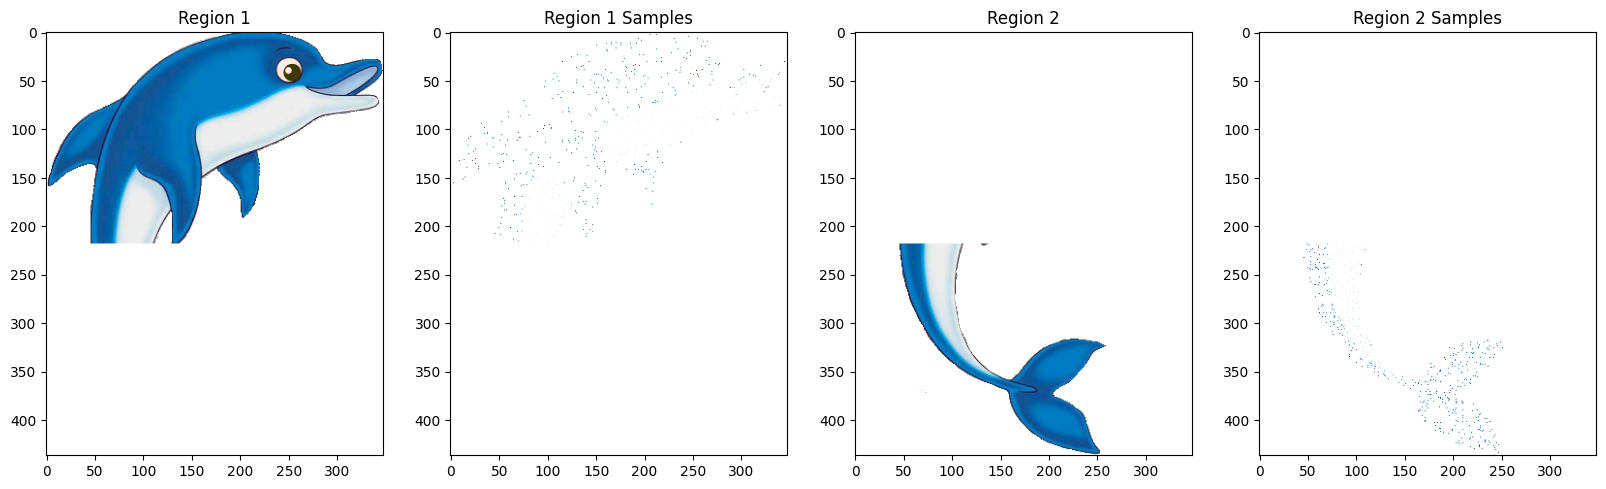

In [289]:
# Define image split using polyline
path = mp.path.Path(jnp.array([[0,-1],[img_rgba.shape[0]/2,-1],[img_rgba.shape[0]/2,img_rgba.shape[1]],[0,img_rgba.shape[1]],[0,-1]]))
xi, yi = jnp.indices((mask.shape[0], mask.shape[1]))
coords = jnp.stack((xi, yi), axis=-1)
region_mask = path.contains_points(coords.reshape(coords.shape[0]*coords.shape[1],2)).reshape(coords.shape[0],coords.shape[1],1)
mask_1 = region_mask * jnp.expand_dims(mask, axis=-1)
mask_2 = ~region_mask * jnp.expand_dims(mask, axis=-1)

# Test region sampling
def mask_for_model(x:jax.Array):
    mask1 = jnp.zeros_like(mask_1).at[(x[0,:,0]*img_rgba.shape[0]).astype(int), (x[0,:,1]*img_rgba.shape[1]).astype(int)].set(True)
    mask2 = jnp.zeros_like(mask_1).at[(x[1,:,0]*img_rgba.shape[0]).astype(int), (x[1,:,1]*img_rgba.shape[1]).astype(int)].set(True)
    return mask1, mask2
x, _ = sample_img_regions(colors, mask, batch_size, key, jnp.squeeze(mask_1))
sample_mask_1, sample_mask_2 = mask_for_model(x)

# Plot both regions
fig, ax = plt.subplots(1,4, figsize=(20,10))

ax[0].imshow(jnp.concat((colors,mask_1), axis=-1))
ax[0].set_title("Region 1")
ax[1].imshow(jnp.concat((colors,sample_mask_1), axis=-1))
ax[1].set_title("Region 1 Samples")
ax[2].imshow(jnp.concat((colors,mask_2), axis=-1))
ax[2].set_title("Region 2")
ax[3].imshow(jnp.concat((colors,sample_mask_2), axis=-1))
ax[3].set_title("Region 2 Samples")


Helper Functions

In [290]:
# Predict with model
@jit
def forward(p, x:jax.Array):
    for W, b in p:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    return x
    
# Mean squared error loss function
# The error is only counted from the model assigned to the queried region
@jit
def loss(p, x:jax.Array, y:jax.Array):
    # Loop through input based on assigned region to predict
    # with respetive model
    preds = []
    for i, (name, model) in enumerate(p.__dict__.items()):
        preds.append(jax.vmap(lambda x: forward(model, x))(x[i])) 
    preds = jnp.stack(preds,axis=0)
    
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def compare_image_region_predict(p):
    # Generate full predicted image
    ## Generate coordinates
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(H)
    coords = coords.at[...,1].divide(W)

    ## Pre-process input and assign to model regions
    ## Query pixels with respective model
    x = [coords[region_mask.flatten()], coords[~region_mask.flatten()]]
    preds = []
    for i, (name, model) in enumerate(p.__dict__.items()):
        preds.append(jax.vmap(lambda x: forward(model, x))(x[i])) 
    preds = jnp.concat(preds,axis=0)
    pred_colors = jnp.clip(preds.reshape( H, W, C),0,1)

    # Display original and predicted image
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(pred_colors)
    ax[1].set_title("Output")
    ax[2].imshow(jnp.concat([pred_colors, mask.reshape(H,W, 1)], axis=-1))
    ax[2].set_title("Output Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

Training loop

Epoch 1900, Loss: 0.010712968185544014


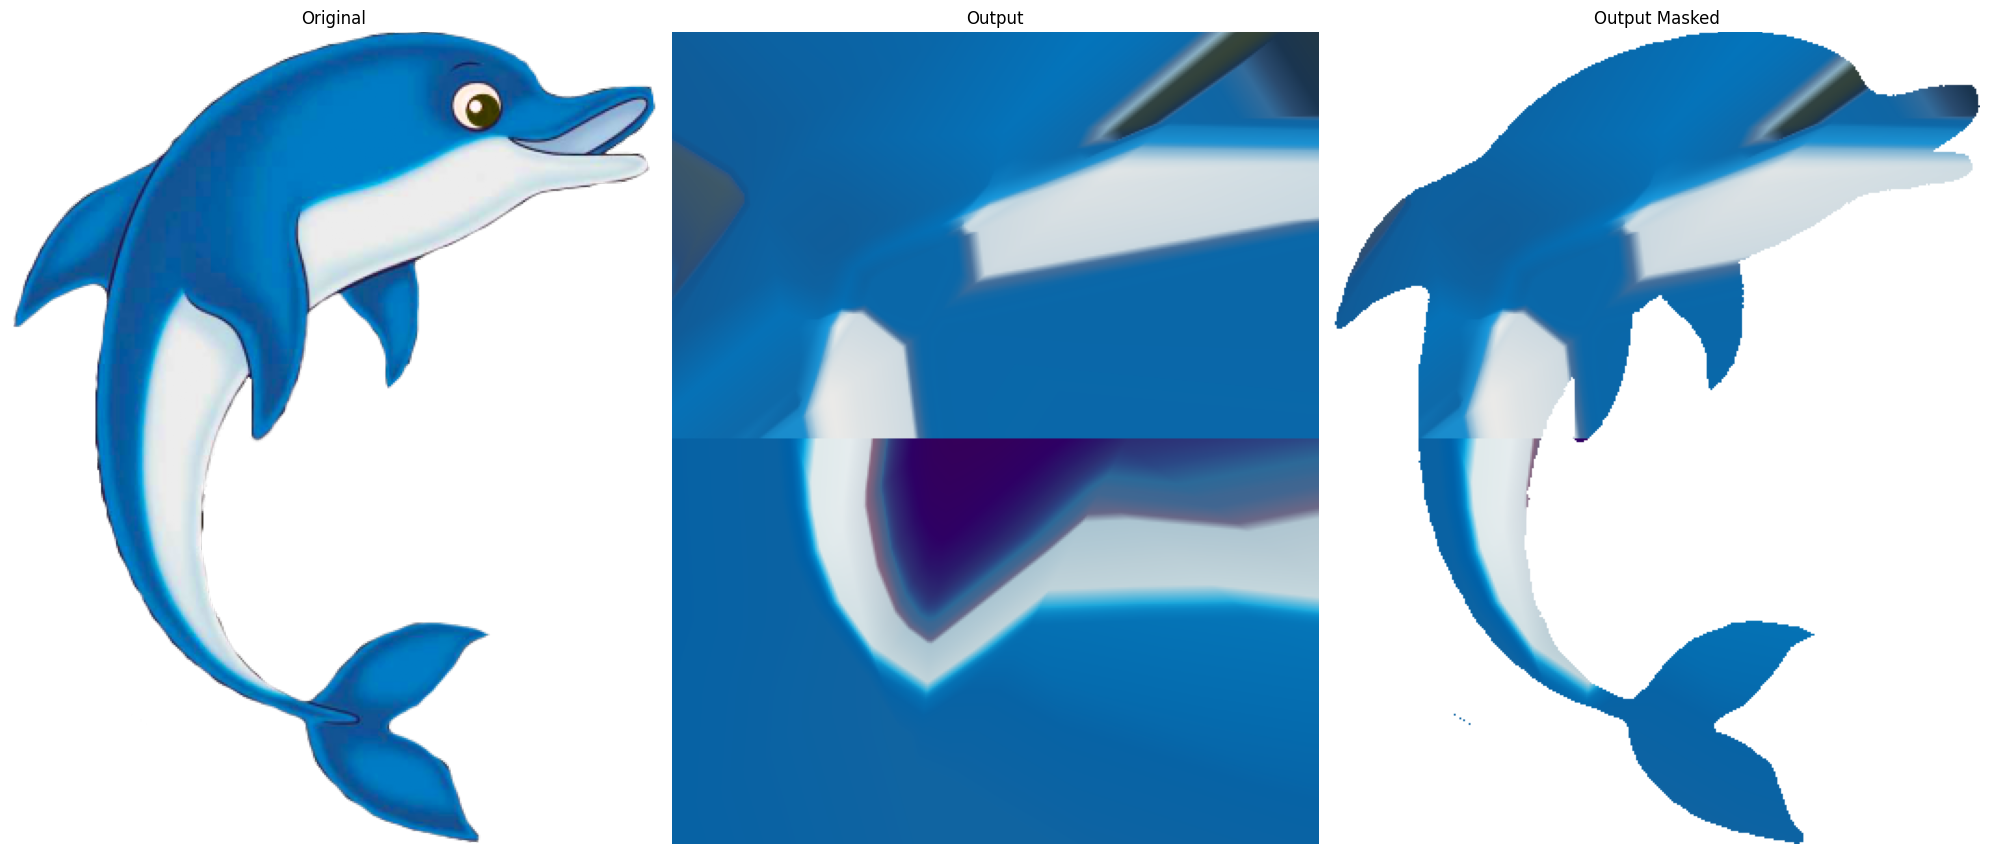

In [297]:
# Hyperparameter
class Params(struct.PyTreeNode):
    model0: list
    model1: list
p = Params(
    model0=init_mlp([2, 8, 8, 8, 8, 8, 8, 8, 8, 3], key), 
    model1=init_mlp([2, 8, 8, 8, 8, 8, 8, 8, 8, 3], key)
)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(p)
num_epochs = 2000
batch_size = 1024

# Just in time compiled update function for speed up training
@jit
def update(p:dict, opt_state, x:jax.Array, y:jax.Array):
    grads = grad(loss)(p, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img_regions(colors, mask, batch_size, key, jnp.squeeze(region_mask))
    p, opt_state = update(p, opt_state, x, y)
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(p, x, y)}")
        compare_image_region_predict(p)

In [298]:
# Evaluate accuracy and inference time based on full image
H, W, C = colors.shape
coords = jnp.indices((H, W)).reshape(2,-1).T
coords = coords.at[...,0].divide(W)
coords = coords.at[...,1].divide(H)
## Pre-process input and assign to model regions
## Query pixels with respective model
x = [coords[region_mask.flatten()], coords[~region_mask.flatten()]]
preds = []
# Measure inference time for image 100 times and take average
# Otherwise the time jumps sometimes significantly
inf_timing = []
for i in range(100):
    preds = []
    time0 = time.time()
    for i, (name, model) in enumerate(p.__dict__.items()):
        preds.append(jax.vmap(lambda x: forward(model, x))(x[i]))
    time1 = time.time()
    inf_timing.append(time1 - time0)
inf_timing = jnp.mean(jnp.array(inf_timing))
preds = jnp.concat(preds,axis=0)
pred_colors = jnp.clip(preds.reshape( H, W, C),0,1)
alpha_pred_colors = pred_colors * jnp.tile(mask[:,:,None], (1,1,3))
accuracy = jnp.mean((img_rgba[...,0:3] - alpha_pred_colors)**2)

# Extract architecture
architecture = {}
architecture["mlp count"] = 2
architecture["layer count"] = len(p.model0)
para = []
for l in p.model0:
    para.append(len(l[0]))
para.append(len(p.model0[-1][1]))
architecture["layers"] = para

# Cache data
model_name = "d_mlp203"
performance_data_collection[model_name] = {}
performance_data_collection[model_name]["mean2 error"] = round(float(accuracy), 6)
performance_data_collection[model_name]["inference"] = round(float(inf_timing), 6)
performance_data_collection[model_name]["training"] = None
performance_data_collection[model_name]["architecture"] = architecture
performance_data_collection

{'d_mlp100': {'mean2 error': 0.013089,
  'inference': 0.025586,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 11,
   'layers': [2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 3]}},
 'd_mlp101': {'mean2 error': 0.01298,
  'inference': 0.035829,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 7,
   'layers': [2, 32, 32, 32, 32, 32, 32, 3]}},
 'd_mlp102': {'mean2 error': 0.019355,
  'inference': 0.0067,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 4,
   'layers': [2, 8, 8, 8, 3]}},
 'd_mlp103': {'mean2 error': 0.040329,
  'inference': 0.079094,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 4,
   'layers': [2, 128, 128, 128, 3]}},
 'd_mlp200': {'mean2 error': 0.022773,
  'inference': 0.005039,
  'training': None,
  'architecture': {'mlp count': 2,
   'layer count': 4,
   'layers': [2, 8, 8, 8, 3]}},
 'd_mlp201': {'mean2 error': 0.043802,
  'inference': 0.051778,
  'training': None,
  'arc

### #4 - MoE soft gating for one image
Two MLP for one image, best split is result of clasifcying space using a network (~MoE)

In [312]:
jax.config.update("jax_disable_jit", False) # True disables jit, False enables jit

Helper functions

In [343]:
# Structure to hold all MoE parameters
class Params(struct.PyTreeNode):
    model0: list
    model1: list
    gate: list

# Forward through expert network
@jit
def forward_expert(expert_params, x):
    for W, b in expert_params:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    return x

# Forward through gate network and pick top K
@jit
def forward_gate(params, x:jax.Array):
    for W, b in params[:-1]:
        x = jax.nn.leaky_relu(jnp.dot(x, W) + b, 0.01)
    final_w, final_b = params[-1]
    x = jax.nn.softmax(jax.nn.sigmoid(jnp.dot(x, final_w) + final_b))
    return x

# Forward through MoE
@jit
def forward(params, x:jax.Array):
    # Gating
    gate = jax.vmap(lambda x: forward_gate(params.gate, x))(x)

    # Experting
    # Shape : [sample, num_experts, RGB]
    e0_out = jax.vmap(lambda x: forward_expert(params.model0, x))(x)
    e1_out = jax.vmap(lambda x: forward_expert(params.model1, x))(x)
    final_pred = jnp.sum(jnp.tile(gate[:,None,:], (1,3,1)) * jnp.stack((e0_out, e1_out), axis=-1), axis=-1)

    return final_pred
    
# Mean squared error loss function
# The error is only counted from the model assigned to the queried region
@jit
def loss(params, x:jax.Array, y:jax.Array):
    preds = forward(params, x)
    return jnp.mean((preds - y) ** 2)

# Display image comparison between learned and original
def compare_image_region_predict(params:Params):
    # Generate coordinates
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(H)
    coords = coords.at[...,1].divide(W)

    # Generate full predicted image intensities
    pred_colors = forward(params, coords)
    pred_colors = jnp.clip(pred_colors.reshape( H, W, C),0,1)

    # Generate gating segmentation map
    @jit
    def get_gating(coords):return jax.vmap(lambda coords: forward_gate(params.gate, coords))(coords)
    segmentation_map = get_gating(coords)[...,0].reshape( H, W, 1) # Since only two gate activation that sum 1 we use one as color mapping

    # Display original and predicted image
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(segmentation_map, cmap="binary")
    ax[1].set_title("Gating Segmentation")
    ax[2].imshow(pred_colors)
    ax[2].set_title("Output")
    ax[3].imshow(jnp.concat([pred_colors, mask.reshape(H,W, 1)], axis=-1))
    ax[3].set_title("Output Masked")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

Traininig loop

Epoch 1900, Loss: 0.013067508116364479


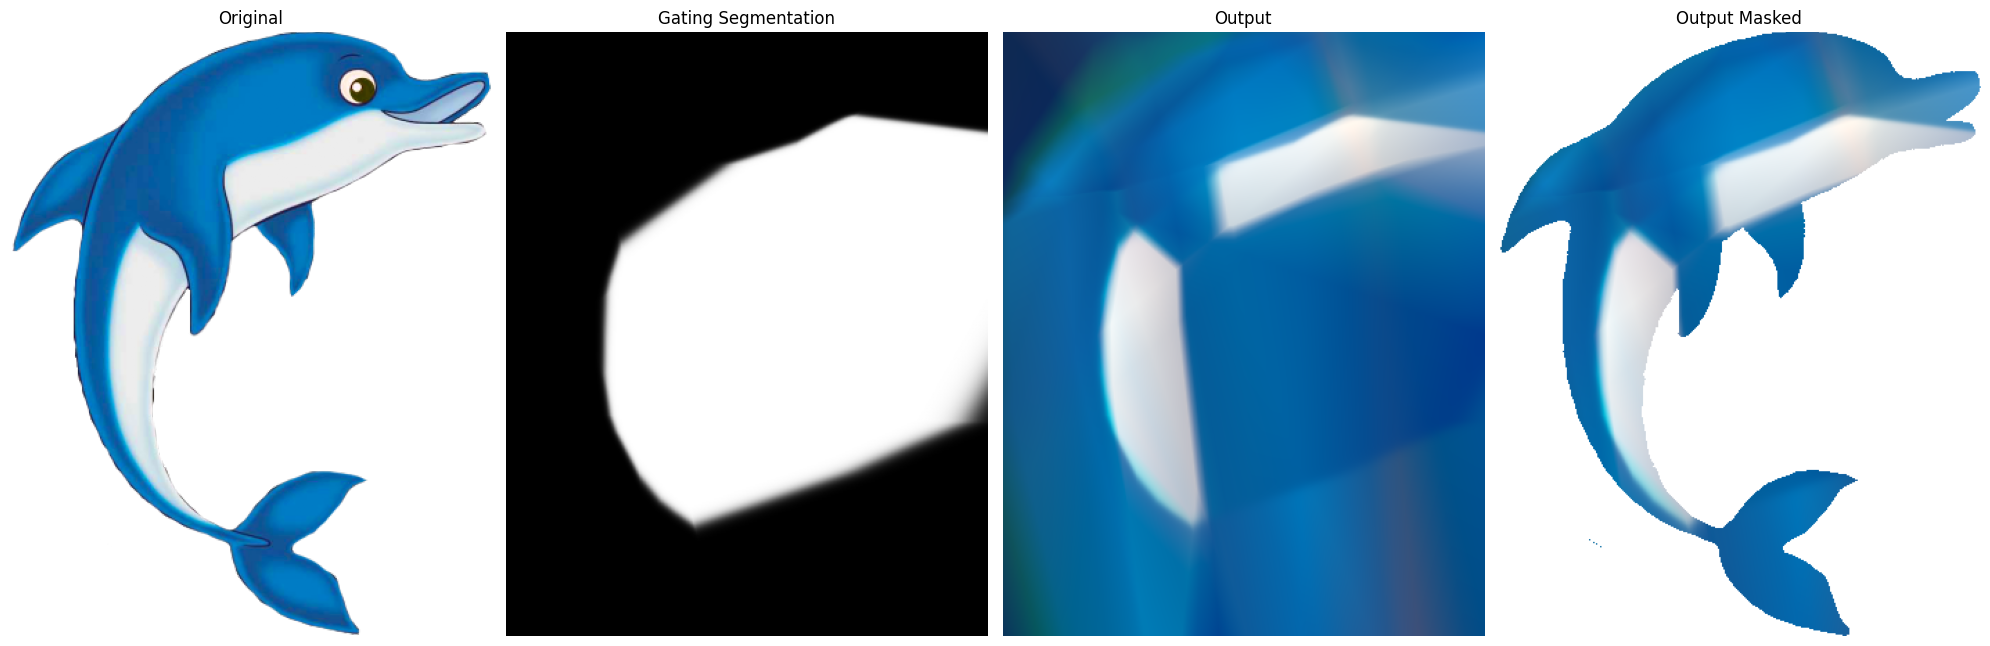

Plot computed in: 0.628868818283081s
Epoch 1901, Loss: 0.010487634688615799
Epoch 1902, Loss: 0.00863570999354124
Epoch 1903, Loss: 0.009757252410054207
Epoch 1904, Loss: 0.011036602780222893
Epoch 1905, Loss: 0.009759273380041122
Epoch 1906, Loss: 0.011587793938815594
Epoch 1907, Loss: 0.01311616413295269
Epoch 1908, Loss: 0.010089457035064697
Epoch 1909, Loss: 0.010737244039773941
Epoch 1910, Loss: 0.011369923129677773
Epoch 1911, Loss: 0.011713013052940369
Epoch 1912, Loss: 0.01402238942682743
Epoch 1913, Loss: 0.011963240802288055
Epoch 1914, Loss: 0.013102369382977486
Epoch 1915, Loss: 0.012647341936826706
Epoch 1916, Loss: 0.010732883587479591
Epoch 1917, Loss: 0.013536719605326653
Epoch 1918, Loss: 0.01197261642664671
Epoch 1919, Loss: 0.012754956260323524
Epoch 1920, Loss: 0.012760773301124573
Epoch 1921, Loss: 0.011599774472415447
Epoch 1922, Loss: 0.011792115867137909
Epoch 1923, Loss: 0.014420258812606335
Epoch 1924, Loss: 0.012707671150565147
Epoch 1925, Loss: 0.01160890143

In [344]:
# Hyperparameter
keys = random.split(key,3)
params = Params(
    model0=init_mlp([2, 32, 32, 32, 3], keys[0]), 
    model1=init_mlp([2, 32, 32, 32, 3], keys[1]),
    gate=init_mlp([2, 16, 16, 16, 2], keys[2])
)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)
num_epochs = 2000
batch_size = 1024
subkey = random.split(key, 1)[0]

# Just in time compiled update function for speed up training
@jit
def update(params, opt_state, x:jax.Array, y:jax.Array):
    grads = grad(loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Training loop
for epoch in range(num_epochs):
    subkey = random.split(subkey, 1)[0]
    x, y = sample_img(colors, mask, batch_size, subkey)
    params, opt_state = update(params, opt_state, x, y)
    print(f"Epoch {epoch}, Loss: {loss(params, x, y)}")
    
    if epoch % 100 == 0:
        ip.display.clear_output(wait=True)
        print(f"Epoch {epoch}, Loss: {loss(params, x, y)}")
        s = time.time()
        compare_image_region_predict(params)
        print(f"Plot computed in: {time.time() - s}s")

In [345]:
# Evaluate accuracy and inference time based on full image
H, W, C = colors.shape
coords = jnp.indices((H, W)).reshape(2,-1).T
coords = coords.at[...,0].divide(W)
coords = coords.at[...,1].divide(H)
# Measure inference time for image 100 times and take average
# Otherwise the time jumps sometimes significantly
inf_timing = []
for i in range(100):
    time0 = time.time()
    pred_colors = forward(params, coords)
    time1 = time.time()
    inf_timing.append(time1 - time0)
inf_timing = jnp.mean(jnp.array(inf_timing))

pred_colors = jnp.clip(pred_colors.reshape( H, W, C),0,1)
alpha_pred_colors = pred_colors * jnp.tile(mask[:,:,None], (1,1,3))
accuracy = jnp.mean((img_rgba[...,0:3] - alpha_pred_colors)**2)

# Extract architecture
architecture = {}
# gate
architecture["gate"] = {}
architecture["gate"]["layer count"] = len(params.gate)
para = []
for l in params.gate:
    para.append(len(l[0]))
para.append(len(params.gate[-1][1]))
architecture["gate"]["layers"] = para
# expert
architecture["expert"] = {}
architecture["expert"]["expert count"] = 2
architecture["expert"]["layer count"] = len(params.gate)
para = []
for l in params.model0:
    para.append(len(l[0]))
para.append(len(params.model0[-1][1]))
architecture["expert"]["layers"] = para

# Cache data
model_name = "d_moe404"
performance_data_collection[model_name] = {}
performance_data_collection[model_name]["mean2 error"] = round(float(accuracy), 6)
performance_data_collection[model_name]["inference"] = round(float(inf_timing), 6)
performance_data_collection[model_name]["training"] = None
performance_data_collection[model_name]["architecture"] = architecture
performance_data_collection

{'d_mlp100': {'mean2 error': 0.02555,
  'inference': 0.023851,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 12,
   'layers': [2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 3]}},
 'd_mlp101': {'mean2 error': 0.027415,
  'inference': 0.036402,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 7,
   'layers': [2, 32, 32, 32, 32, 32, 32, 3]}},
 'd_mlp102': {'mean2 error': 0.02476,
  'inference': 0.006709,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 4,
   'layers': [2, 8, 8, 8, 3]}},
 'd_mlp103': {'mean2 error': 0.04347,
  'inference': 0.077408,
  'training': None,
  'architecture': {'mlp count': 1,
   'layer count': 4,
   'layers': [2, 128, 128, 128, 3]}},
 'd_mlp200': {'mean2 error': 0.022773,
  'inference': 0.005039,
  'training': None,
  'architecture': {'mlp count': 2,
   'layer count': 4,
   'layers': [2, 8, 8, 8, 3]}},
 'd_mlp201': {'mean2 error': 0.043802,
  'inference': 0.051778,
  'training': None,
  

### Comparison Plot
Rank all architectures in a plot with speef and quality.

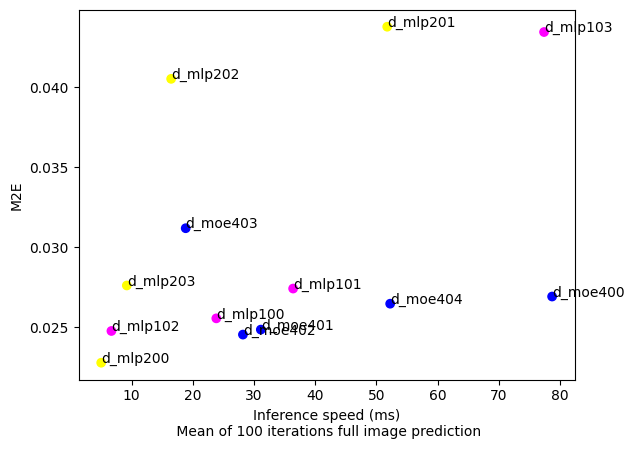

In [347]:
color = ["magenta"] * 4 + ["yellow"] * 4 + ["blue"] * 5
name, error, inference = [], [], []
for m in performance_data_collection:
    error.append(performance_data_collection[m]["mean2 error"])
    name.append(m)
    # convert to miliseconds / 1s = 1000ms
    inference.append(performance_data_collection[m]["inference"] * 1000)

plt.scatter(inference, error, c=color)
plt.ylabel("M2E")
plt.xlabel("Inference speed (ms)\n Mean of 100 iterations full image prediction")
for i in range(len(name)):
    plt.annotate(name[i], (inference[i], error[i]))